# Fine-tuning for Semantic Segmentation with 🤗 Transformers

This tutorial shows how to fine-tune a SegFormer model in TensorFlow for the task of semantic segmentation. The tutorial is a TensorFlow port of this [blog post](https://huggingface.co/blog/fine-tune-segformer). As such, the notebook uses code from the blog post.

This notebook shows how to fine-tune a pretrained vision model for Semantic Segmentation on a custom dataset. The idea is to add a randomly initialized segmentation head on top of a pre-trained encoder, and fine-tune the model altogether on a labeled dataset.

## Model

This notebook is built for the [SegFormer model (TensorFlow variant)](https://huggingface.co/docs/transformers/model_doc/segformer#transformers.TFSegformerForSemanticSegmentation) and is supposed to run on any semantic segmentation dataset. You can adapt this notebook to other supported semantic segmentation models such as [MobileViT](https://huggingface.co/docs/transformers/model_doc/mobilevit).

## Data augmentation

This notebook leverages TensorFlow's [`image`](https://www.tensorflow.org/api_docs/python/tf/image) module for applying data augmentation. Using other augmentation libraries like `albumentations` is also [supported](https://github.com/huggingface/notebooks/blob/main/examples/image_classification_albumentations.ipynb).

---

Depending on the model and the GPU you are using, you might need to adjust the batch size to avoid out-of-memory errors. Set those two parameters, then the rest of the notebook should run smoothly.

In this notebook, we'll fine-tune from the https://huggingface.co/nvidia/mit-b0 checkpoint, but note that there are others [available on the hub](https://huggingface.co/models?pipeline_tag=image-segmentation).

In [1]:
model_checkpoint = "nvidia/mit-b0"  # pre-trained model from which to fine-tune
batch_size = 4  # batch size for training and evaluation

Before we start, let's install the `datasets`, `transformers`, and `evaluate` libraries. We also install Git-LFS to upload the model checkpoints to Hub.



In [2]:
!pip -q install datasets transformers evaluate

!git lfs install
!git config --global credential.helper store

     |████████████████████████████████| 441 kB 27.3 MB/s 
     |████████████████████████████████| 5.5 MB 90.7 MB/s 
     |████████████████████████████████| 72 kB 1.7 MB/s 
     |████████████████████████████████| 212 kB 88.9 MB/s 
     |████████████████████████████████| 115 kB 93.0 MB/s 
     |████████████████████████████████| 163 kB 92.6 MB/s 
     |████████████████████████████████| 95 kB 6.3 MB/s 
     |████████████████████████████████| 127 kB 89.3 MB/s 
     |████████████████████████████████| 7.6 MB 76.1 MB/s 
     |████████████████████████████████| 115 kB 89.3 MB/s 
Error: Failed to call git rev-parse --git-dir --show-toplevel: "fatal: not a git repository (or any of the parent directories): .git\n"
Git LFS initialized.


If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.

You can share the resulting model with the community. By pushing the model to the Hub, others can discover your model and build on top of it. You also get an automatically generated model card that documents how the model works and a widget that will allow anyone to try out the model directly in the browser. To enable this, you'll need to login to your account.

In [3]:
from huggingface_hub import notebook_login

notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token


## Fine-tuning a model on a semantic segmentation task

In this notebook, we will see how to fine-tune one of the [🤗 Transformers](https://github.com/huggingface/transformers) vision models on a Semantic Segmentation dataset.

Given an image, the goal is to associate each and every pixel to a particular category (such as table). The screenshot below is taken from a [SegFormer fine-tuned on ADE20k](https://huggingface.co/nvidia/segformer-b0-finetuned-ade-512-512) - try out the inference widget!

<img src="https://i.ibb.co/8B8xy1R/image.png" alt="drawing" width="600"/>



### Loading the dataset

We will use the [🤗 Datasets](https://github.com/huggingface/datasets) library to download our custom dataset into a [`DatasetDict`](https://huggingface.co/docs/datasets/package_reference/main_classes.html#datasetdict).

In [4]:
from datasets import load_dataset

hf_dataset_identifier = "segments/sidewalk-semantic"
ds = load_dataset(hf_dataset_identifier)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

0 tables [00:00, ? tables/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/segments___parquet/segments--sidewalk-semantic-2-007b1ee78ca1e890/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

We're using the Sidewalk dataset which is dataset of sidewalk images gathered in Belgium in the summer of 2021. You can learn more about the dataset [here](https://huggingface.co/datasets/segments/sidewalk-semantic).

Let us also load the Mean IoU metric, which we'll use to evaluate our model both during and after training. 

IoU (short for Intersection over Union) tells us the amount of overlap between two sets. In our case, these sets will be the ground-truth segmentation map and the predicted segmentation map. To learn more, you can check out [this article](https://learnopencv.com/intersection-over-union-iou-in-object-detection-and-segmentation/).

In [5]:
import evaluate

metric = evaluate.load("mean_iou")

The `ds` object itself is a `DatasetDict`, which contains one key per split (in this case, only "train" for a training split).

In [6]:
ds

DatasetDict({
    train: Dataset({
        features: ['pixel_values', 'label'],
        num_rows: 1000
    })
})

Here, the `features` tell us what each example is consisted of:

* `pixel_values`: the actual image
* `label`: segmentation mask



To access an actual element, you need to select a split first, then give an index:

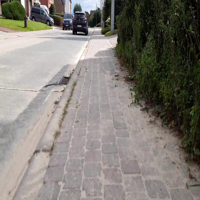

In [7]:
example = ds["train"][10]
example["pixel_values"].resize((200, 200))

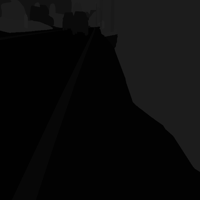

In [8]:
example["label"].resize((200, 200))

Each of the pixels above can be associated to a particular category. Let's load all the categories that are associated with the dataset. Let's also create an `id2label` dictionary to decode them back to strings and see what they are. The inverse `label2id` will be useful too, when we load the model later.

In [11]:
from huggingface_hub import hf_hub_download
import json

filename = "id2label.json"
id2label = json.load(
    open(hf_hub_download(hf_dataset_identifier, filename, repo_type="dataset"), "r")
)
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}

num_labels = len(id2label)

Downloading:   0%|          | 0.00/852 [00:00<?, ?B/s]

In [12]:
num_labels, list(label2id.keys())

(35,
 ['unlabeled',
  'flat-road',
  'flat-sidewalk',
  'flat-crosswalk',
  'flat-cyclinglane',
  'flat-parkingdriveway',
  'flat-railtrack',
  'flat-curb',
  'human-person',
  'human-rider',
  'vehicle-car',
  'vehicle-truck',
  'vehicle-bus',
  'vehicle-tramtrain',
  'vehicle-motorcycle',
  'vehicle-bicycle',
  'vehicle-caravan',
  'vehicle-cartrailer',
  'construction-building',
  'construction-door',
  'construction-wall',
  'construction-fenceguardrail',
  'construction-bridge',
  'construction-tunnel',
  'construction-stairs',
  'object-pole',
  'object-trafficsign',
  'object-trafficlight',
  'nature-vegetation',
  'nature-terrain',
  'sky',
  'void-ground',
  'void-dynamic',
  'void-static',
  'void-unclear'])

**Note**: This dataset specificaly sets the 0th index as being `unlabeled`. We want to take this information into consideration while computing the loss. Specifically, mask the pixels for which the network predicted `unlabeled` and don't compute loss for it since they don't contribute to training that much. 

### Preprocessing the data

Before we can feed these images to our model, we need to preprocess them. 

Preprocessing images typically comes down to (1) resizing them to a particular size (2) normalizing the color channels (R,G,B) using a mean and standard deviation. These are referred to as **image transformations**.

To make sure we (1) resize to the appropriate size (2) use the appropriate image mean and standard deviation for the model architecture we are going to use, we instantiate what is called an image processor with the `AutoImageProcessor.from_pretrained` method.

This image processor is a minimal preprocessor that can be used to prepare images for model training and inference.

In [ ]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

In [ ]:
import tensorflow as tf


def transforms(image):
    image = tf.keras.utils.img_to_array(image)
    image = image.transpose(
        (2, 0, 1)
    )  # Since vision models in transformers are channels-first layout
    return image


def preprocess(example_batch):
    images = [transforms(x.convert("RGB")) for x in example_batch["pixel_values"]]
    labels = [x for x in example_batch["label"]]
    inputs = image_processor(images, labels)
    return inputs

Next, we can preprocess our dataset by applying these functions. We will use the set_transform functionality, which allows to apply the functions above on-the-fly (meaning that they will only be applied when the images are loaded in RAM).

In [ ]:
# split up training into training + validation
splits = ds["train"].train_test_split(test_size=0.1)
train_ds = splits["train"]
val_ds = splits["test"]

In [ ]:
train_ds.set_transform(preprocess)
val_ds.set_transform(preprocess)

### Training the model

Now that our data is ready, we can download the pretrained model and fine-tune it. We will the `TFSegformerForSemanticSegmentation` class. Calling the `from_pretrained` method on it will download and cache the weights for us. As the label ids and the number of labels are dataset dependent, we pass `label2id`, and `id2label` alongside the `model_checkpoint` here. This will make sure a custom segmentation head will be created (with a custom number of output neurons).

In [ ]:
from transformers import TFSegformerForSemanticSegmentation


model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,  # Will ensure the segmentation specific components are reinitialized.
)

The warning is telling us we are throwing away some weights (the weights and bias of the `decode_head` layer) and randomly initializing some other (the weights and bias of a new `decode_head` layer). This is expected in this case, because we are adding a new head for which we don't have pretrained weights, so the library warns us we should fine-tune this model before using it for inference, which is exactly what we are going to do.

In [ ]:
epochs = 50
lr = 0.00006

Note that most models on the Hub compute loss internally, so we actually don't have to specify anything there! Leaving the loss field blank will cause the model to read the loss head as its loss value.

This is an unusual quirk of TensorFlow models in 🤗 Transformers, so it's worth elaborating on in a little more detail. All 🤗 Transformers models are capable of computing an appropriate loss for their task internally (for example, a CausalLM model will use a cross-entropy loss). To do this, the labels must be provided in the input dict (or equivalently, in the `columns` argument to `to_tf_dataset()`), so that they are visible to the model during the forward pass.

This is quite different from the standard Keras way of handling losses, where labels are passed separately and not visible to the main body of the model, and loss is handled by a function that the user passes to `compile()`, which uses the model outputs and the label to compute a loss value.

The approach we take is that if the user does not pass a loss to `compile()`, the model will assume you want the **internal** loss. If you are doing this, you should make sure that the labels column(s) are included in the **input dict** or in the `columns` argument to `to_tf_dataset`.

If you want to use your own loss, that is of course possible too! If you do this, you should make sure your labels column(s) are passed like normal labels, either as the **second argument** to `model.fit()`, or in the `label_cols` argument to `to_tf_dataset`.

In [ ]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=lr)
model.compile(optimizer=optimizer)

We need to convert our datasets to a format Keras understands. The easiest way to do this is with the `to_tf_dataset()` method. Note that our data collators are designed to work for multiple frameworks, so ensure you set the `return_tensors='tf'` argument to get TensorFlow tensors out - you don't want to accidentally get a load of `torch.Tensor` objects in the middle of your nice TF code!

In [ ]:
from transformers import DefaultDataCollator


data_collator = DefaultDataCollator(return_tensors="tf")

train_set = train_ds.to_tf_dataset(
    columns=["pixel_values", "label"],
    shuffle=True,
    batch_size=batch_size,
    collate_fn=data_collator,
)
val_set = val_ds.to_tf_dataset(
    columns=["pixel_values", "label"],
    shuffle=False,
    batch_size=batch_size,
    collate_fn=data_collator,
)

`train_set` is now a `tf.data.Dataset` type object. We see that it contains two elements - `labels` and `pixel_values`. :

In [ ]:
train_set.element_spec

{'labels': TensorSpec(shape=(None, 512, 512), dtype=tf.int64, name=None),
 'pixel_values': TensorSpec(shape=(None, 3, 512, 512), dtype=tf.float32, name=None)}

In [ ]:
batch = next(iter(train_set))
batch.keys()

dict_keys(['labels', 'pixel_values'])

In [ ]:
for k in batch: 
    print(f"{k}: {batch[k].shape}")

labels: (4, 512, 512)
pixel_values: (4, 3, 512, 512)


The last thing to define is how to compute the metrics from the predictions. We need to define a function for this, which will just use the metric we loaded earlier. The only preprocessing we have to do is to take the argmax of our predicted logits.

In addition, let's wrap this metric computation function in a `KerasMetricCallback`. This callback will compute the metric on the validation set each epoch, including printing it and logging it for other callbacks like TensorBoard and EarlyStopping.

Why do it this way, though, and not just use a straightforward Keras Metric object? This is a good question - on this task, metrics such as Accuracy are very straightforward, and it would probably make more sense to just use a Keras metric for those instead. However, we want to demonstrate the use of `KerasMetricCallback` here, because it can handle any arbitrary Python function for the metric computation. 

How do we actually use `KerasMetricCallback`? We simply define a function that computes metrics given a tuple of numpy arrays of predictions and labels, then we pass that, along with the validation set to compute metrics on, to the callback:

In [ ]:
from transformers.keras_callbacks import KerasMetricCallback


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # logits are of shape (batch_size, num_labels, height, width), so
    # we first transpose them to (batch_size, height, width, num_labels)
    logits = tf.transpose(logits, perm=[0, 2, 3, 1])
    # scale the logits to the size of the label
    logits_resized = tf.image.resize(
        logits,
        size=tf.shape(labels)[1:],
        method="bilinear",
    )
    # compute the prediction labels and compute the metric
    pred_labels = tf.argmax(logits_resized, axis=-1)
    metrics = metric.compute(
        predictions=pred_labels,
        references=labels,
        num_labels=num_labels,
        ignore_index=-1,
        reduce_labels=image_processor.do_reduce_labels,
    )
    # add per category metrics as individual key-value pairs
    per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
    per_category_iou = metrics.pop("per_category_iou").tolist()

    metrics.update(
        {f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)}
    )
    metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})
    return {"val_" + k: v for k, v in metrics.items()}


metric_callback = KerasMetricCallback(
    metric_fn=compute_metrics,
    eval_dataset=val_set,
    batch_size=batch_size,
    label_cols=["labels"],
)

Now we can train our model. We can also add a callback to sync up our model with the Hub - this allows us to resume training from other machines and even test the model's inference quality midway through training! Make sure to change the `username` if you do. If you don't want to do this, simply remove the callbacks argument in the call to `fit()`.

In [ ]:
from transformers.keras_callbacks import PushToHubCallback


model_name = model_checkpoint.split("/")[-1]
push_to_hub_model_id = f"{model_name}-finetuned-sidewalks"

push_to_hub_callback = PushToHubCallback(
    output_dir="./ic_from_scratch_model_save",
    hub_model_id=push_to_hub_model_id,
    tokenizer=image_processor,
)

/content/ic_from_scratch_model_save is already a clone of https://huggingface.co/sayakpaul/mit-b0-finetuned-sidewalks. Make sure you pull the latest changes with `repo.git_pull()`.


In [ ]:
callbacks = [metric_callback, push_to_hub_callback] 

In [ ]:
model.fit(
    train_set,
    validation_data=val_set,
    callbacks=callbacks,
    epochs=epochs,
)

In [ ]:
eval_loss = model.evaluate(val_set)
eval_loss

25/25 [==============================] - 19s 760ms/step - loss: 0.6632


0.6632034778594971

Alternatively, we can also leverage `metric` to compute different quantities on the validation set in a batchwise manner: `mean_iou`, `mean_accuracy`, etc. 

In [ ]:
for batch in iter(val_set):
    predictions = model.predict(batch)
    # logits are of shape (batch_size, num_labels, height, width), so
    # we first transpose them to (batch_size, height, width, num_labels)
    logits = tf.transpose(predictions.logits, perm=[0, 2, 3, 1])
    # scale the logits to the size of the label
    logits_resized = tf.image.resize(
        logits,
        size=tf.shape(batch["labels"])[1:],
        method="bilinear",
    )
    # compute the prediction labels and compute the metric
    pred_labels = tf.argmax(logits_resized, axis=-1)
    metric.add_batch(predictions=pred_labels, references=batch["labels"])

metric.compute(
    num_labels=num_labels,
    ignore_index=-1,
    reduce_labels=image_processor.do_reduce_labels,
)

1/1 [==============================] - 0s 52ms/step


/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in true_divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in true_divide
  acc = total_area_intersect / total_area_label


{'mean_iou': 0.34928452779479446,
 'mean_accuracy': 0.4338651476779283,
 'overall_accuracy': 0.8566543197631836,
 'per_category_iou': array([0.        , 0.72734562, 0.87039109, 0.50560252, 0.51663228,
        0.36229545,        nan, 0.47776689, 0.52940518, 0.19241958,
        0.84155873, 0.02830674, 0.        , 0.        , 0.00139925,
        0.60445893, 0.        , 0.07574025, 0.7468094 , 0.14334183,
        0.4693584 , 0.40891129, 0.14829822,        nan, 0.00813972,
        0.40590805, 0.26146138, 0.        , 0.86026492, 0.83512788,
        0.93070718, 0.0090409 , 0.18828452, 0.37741323, 0.        ]),
 'per_category_accuracy': array([0.        , 0.8310267 , 0.95392068, 0.60428497, 0.61919046,
        0.48613447,        nan, 0.65088444, 0.66893242, 0.25887691,
        0.92731001, 0.04746215, 0.        ,        nan, 0.00160901,
        0.73867496, 0.        , 0.08254848, 0.88137757, 0.16531368,
        0.61751433, 0.47250332, 0.1747851 ,        nan, 0.0144379 ,
        0.4916292 , 0.37

## Inference

Now that the fine-tuning is done, we can perform inference with the model. In this section, we will also compare the model predictions with the ground-truth labels. This comparison will help us determine the plausible next steps.

In [ ]:
hf_dataset_identifier = "segments/sidewalk-semantic"
ds = load_dataset(hf_dataset_identifier)

ds = ds.shuffle(seed=1)
ds = ds["train"].train_test_split(test_size=0.2)
inference = ds["test"]

  0%|          | 0/1 [00:00<?, ?it/s]

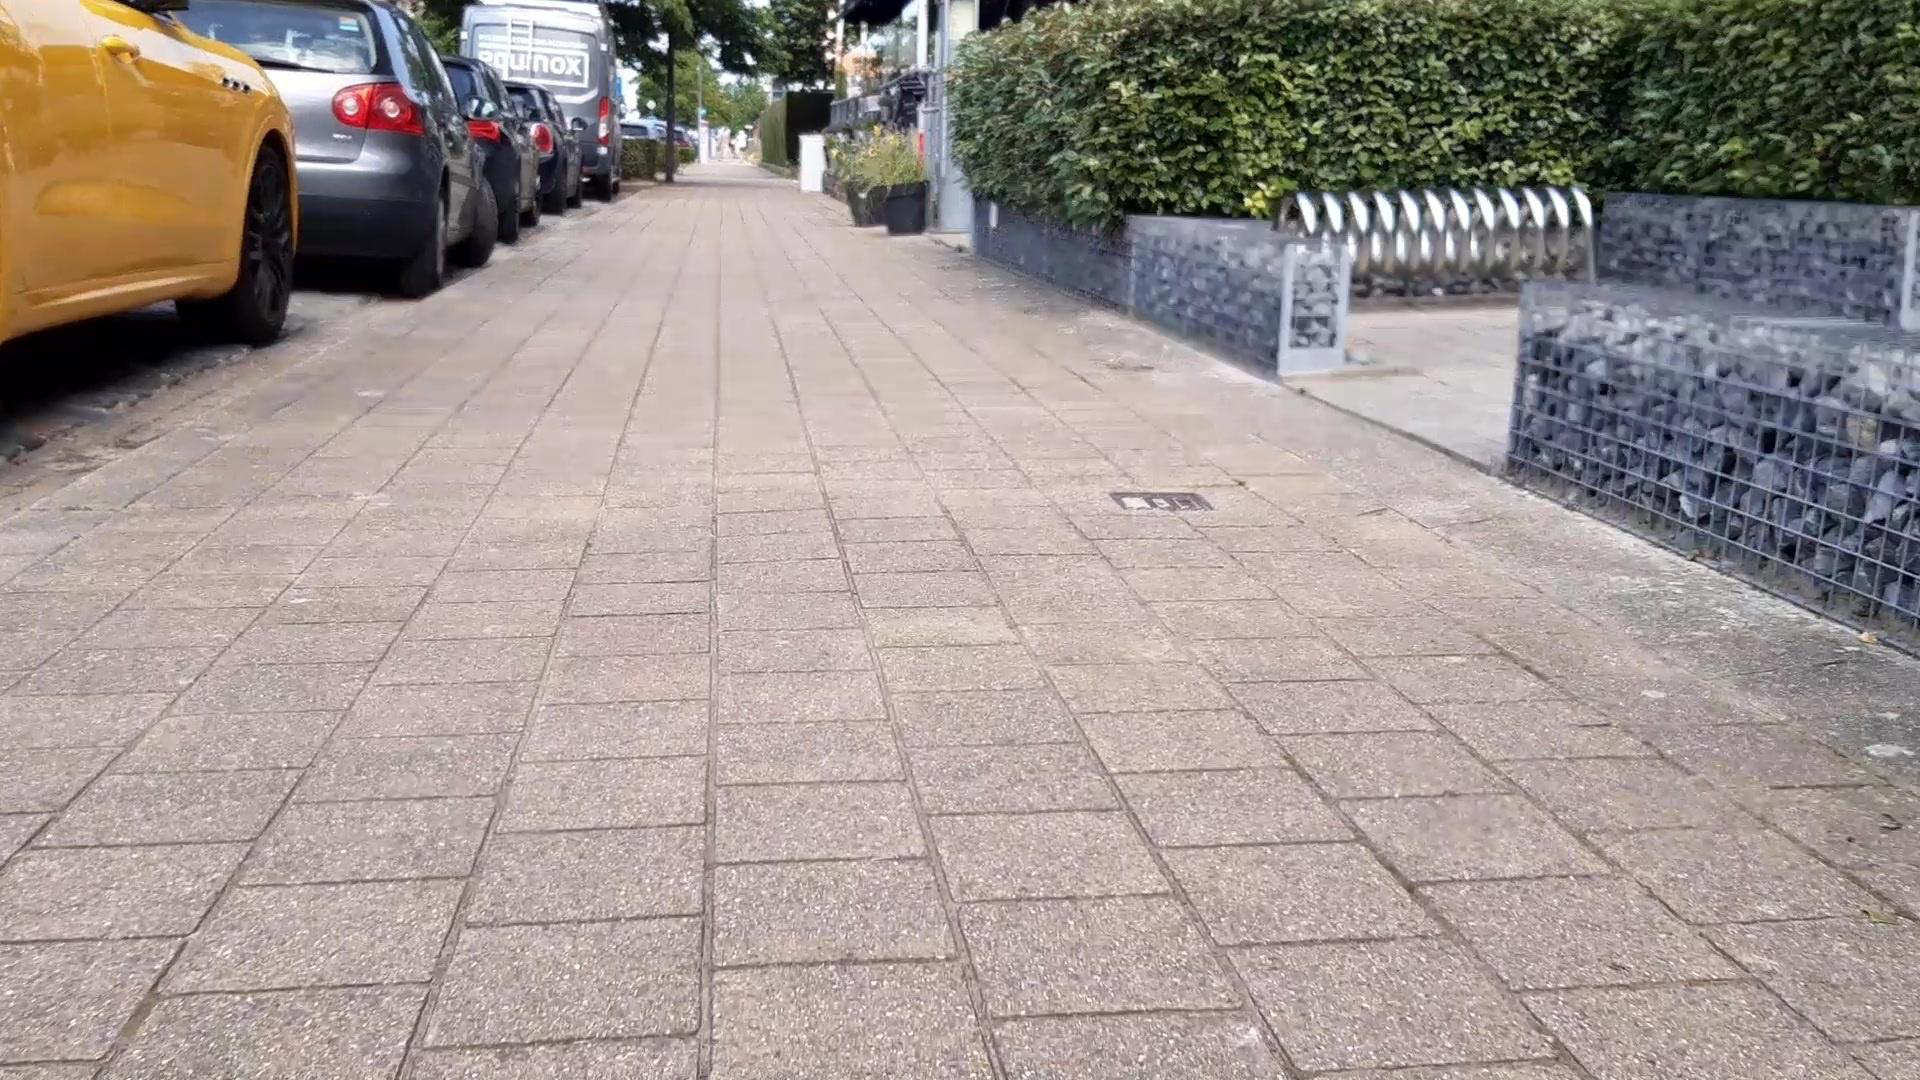

In [ ]:
test_image = inference[0]["pixel_values"]
test_gt = inference[0]["label"]
test_image

In [ ]:
inputs = image_processor(images=test_image, return_tensors="tf")
print(inputs["pixel_values"].shape)

(1, 3, 512, 512)


In [ ]:
outputs = model(**inputs, training=False)
logits = outputs.logits  # shape (batch_size, num_labels, height/4, width/4)

# Transpose to have the shape (batch_size, height/4, width/4, num_labels)
logits = tf.transpose(logits, [0, 2, 3, 1])

# First, rescale logits to original image size
upsampled_logits = tf.image.resize(
    logits,
    # We reverse the shape of `image` because `image.size` returns width and height.
    test_image.size[::-1]  
)

# Second, apply argmax on the class dimension
pred_seg = tf.math.argmax(upsampled_logits, axis=-1)[0]
print(pred_seg.shape)

(1080, 1920)


In [ ]:
def sidewalk_palette():
    """Sidewalk palette that maps each class to RGB values."""
    return [
        [0, 0, 0],
        [216, 82, 24],
        [255, 255, 0],
        [125, 46, 141],
        [118, 171, 47],
        [161, 19, 46],
        [255, 0, 0],
        [0, 128, 128],
        [190, 190, 0],
        [0, 255, 0],
        [0, 0, 255],
        [170, 0, 255],
        [84, 84, 0],
        [84, 170, 0],
        [84, 255, 0],
        [170, 84, 0],
        [170, 170, 0],
        [170, 255, 0],
        [255, 84, 0],
        [255, 170, 0],
        [255, 255, 0],
        [33, 138, 200],
        [0, 170, 127],
        [0, 255, 127],
        [84, 0, 127],
        [84, 84, 127],
        [84, 170, 127],
        [84, 255, 127],
        [170, 0, 127],
        [170, 84, 127],
        [170, 170, 127],
        [170, 255, 127],
        [255, 0, 127],
        [255, 84, 127],
        [255, 170, 127],
    ]

In [ ]:
import numpy as np


def get_seg_overlay(image, seg):
    color_seg = np.zeros(
        (seg.shape[0], seg.shape[1], 3), dtype=np.uint8
    )  # height, width, 3
    palette = np.array(sidewalk_palette())
    for label, color in enumerate(palette):
        color_seg[seg == label, :] = color

    # Show image + mask
    img = np.array(image) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)

    return img

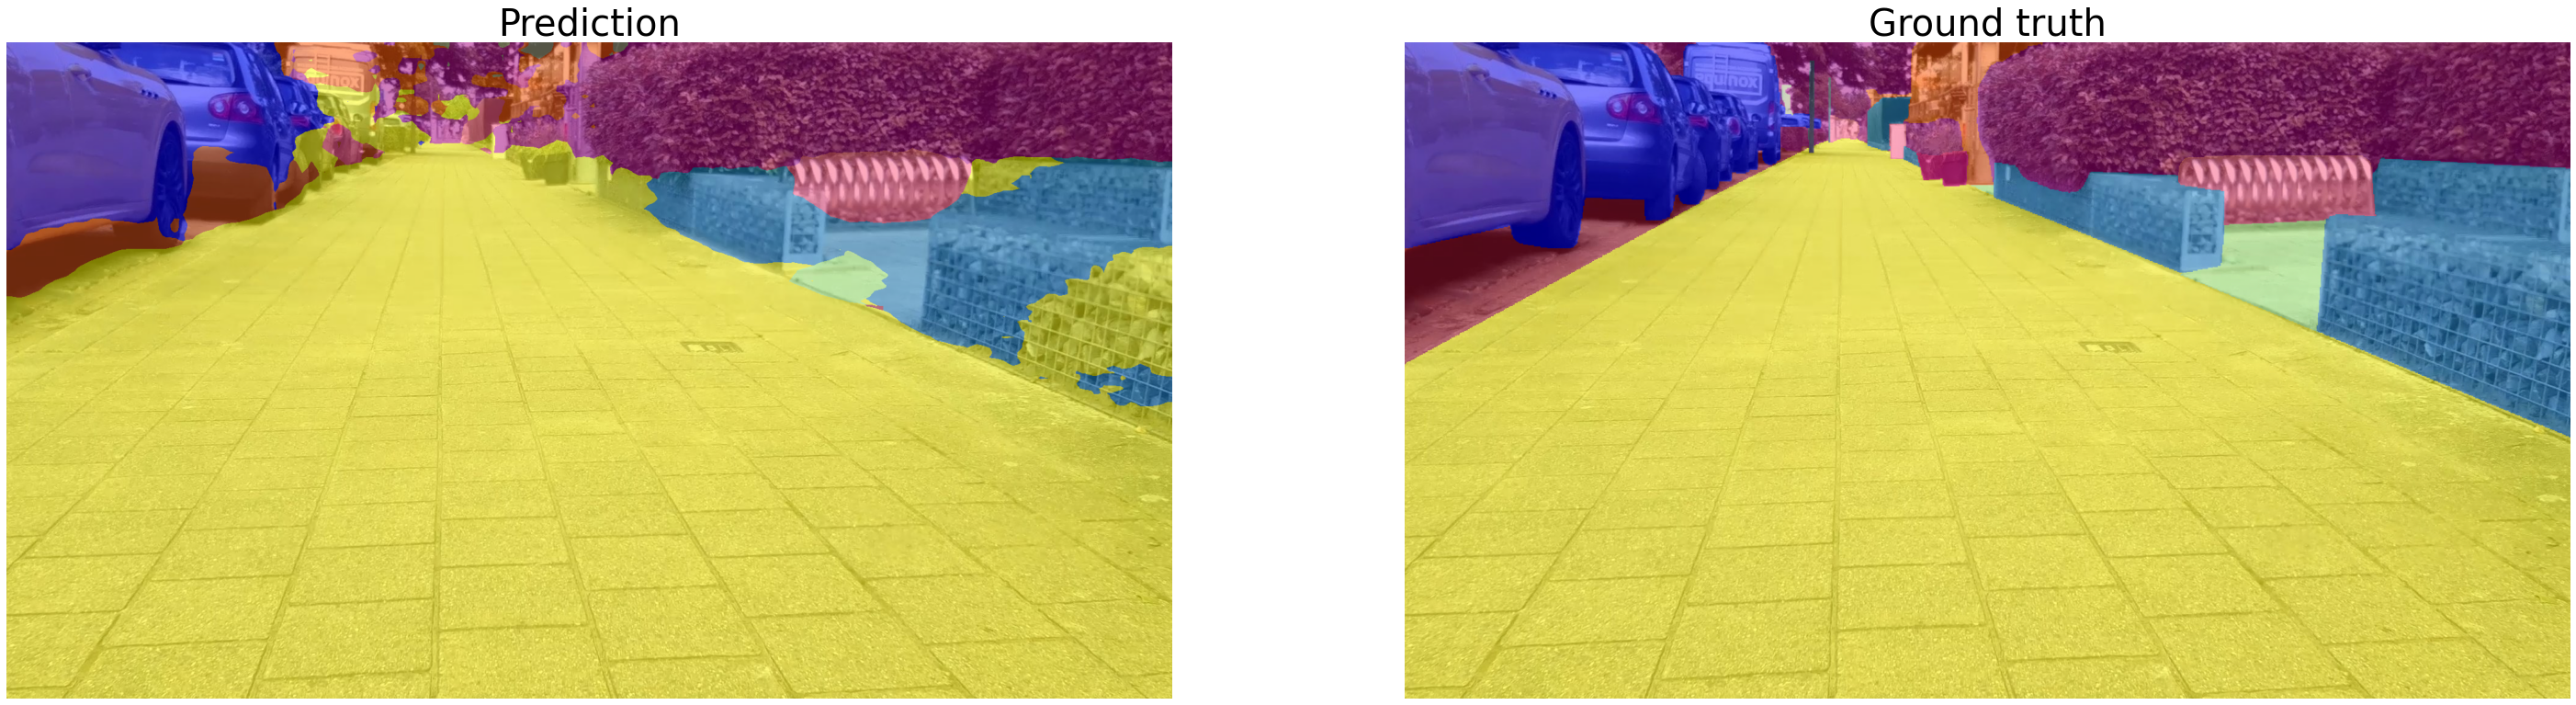

In [ ]:
import matplotlib.pyplot as plt

pred_img = get_seg_overlay(test_image, pred_seg.numpy())
gt_img = get_seg_overlay(test_image, np.array(test_gt))

f, axs = plt.subplots(1, 2)
f.set_figheight(30)
f.set_figwidth(50)

axs[0].set_title("Prediction", {"fontsize": 40})
axs[0].imshow(pred_img)
axs[0].axis("off")
axs[1].set_title("Ground truth", {"fontsize": 40})
axs[1].imshow(gt_img)
axs[1].axis("off")

plt.show()

Our model is not perfect but it's getting there. Here are some ways to make it better:

* Our dataset is small and adding more samples to it will likely help the model.
* We didn't perform any hyperparameter tuning for the model. So, searching for better hyperparameters could be helpful. 
* Finally, using a larger model for fine-tuning could be beneficial.  

You can now share this model with all your friends, family, favorite pets: they can all load it with the identifier `"your-username/the-name-you-picked"` so for instance:

```python
from transformers import TFSegformerForSemanticSegmentation, TFAutoImageProcessor

image_processor = TFAutoImageProcessor.from_pretrained("sayakpaul/my-awesome-model")
model = TFSegformerForSemanticSegmentation.from_pretrained("sayakpaul/my-awesome-model")

```